            Price
Timestamp        
2009-01-31  14702
2009-02-28  14946
2009-03-31  15059
2009-04-30  15237
2009-05-31  15668
...           ...
2019-12-31  50945
2020-01-31  50962
2020-02-29  51129
2020-03-31  51530
2020-04-30  51281

[136 rows x 1 columns]
                   Price
Timestamp               
2009-03-31  14902.333333
2009-06-30  15678.000000
2009-09-30  17271.666667
2009-12-31  18934.666667
2010-03-31  20741.000000
2010-06-30  21899.000000
2010-09-30  21664.666667
2010-12-31  22226.333333
2011-03-31  23342.333333
2011-06-30  23699.333333
2011-09-30  23924.333333
2011-12-31  23224.333333
2012-03-31  21983.000000
2012-06-30  22235.333333
2012-09-30  22670.666667
2012-12-31  23154.000000
2013-03-31  24708.000000
2013-06-30  26725.000000
2013-09-30  27575.666667
2013-12-31  29440.666667
2014-03-31  30324.666667
2014-06-30  30814.000000
2014-09-30  30560.333333
2014-12-31  30482.666667
2015-03-31  31074.000000
2015-06-30  31591.000000
2015-09-30  32792.666667
2015-12-31  34291

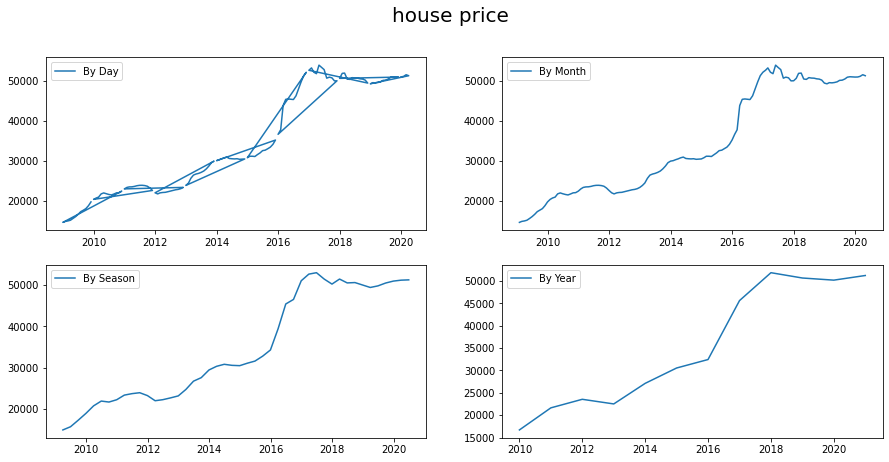

In [0]:
# -*- coding: utf-8 -*-
# 房价数据走势预测，使用时间序列ARMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')
# 数据加载
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/L13/shanghai_clean.csv')
df = df[['Timestamp', 'Price']]
#print(df)

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
# 数据探索
#print(df.head())
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)
print(df_Q)
print(df_year)

# 按照天，月，季度，年来显示沪市指数的走势
fig = plt.figure(figsize=[15, 7])
#plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('house price', fontsize=20)
plt.subplot(221)
plt.plot(df.Price, '-', label='By Day')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='By Month')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Price, '-', label='By Season')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='By Year')
plt.legend()
plt.show()



参数错误: (0, 2)
最优模型:                                ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                  136
Model:                     ARMA(2, 2)   Log Likelihood               -1084.468
Method:                       css-mle   S.D. of innovations            682.981
Date:                Mon, 13 Apr 2020   AIC                           2180.936
Time:                        02:46:25   BIC                           2198.412
Sample:                    01-31-2009   HQIC                          2188.038
                         - 04-30-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.383e+04        nan        nan        nan         nan         nan
ar.L1.Price     1.9226      0.008    245.616      0.000       1.907       1.938
ar.L2.Price    -0.9229      

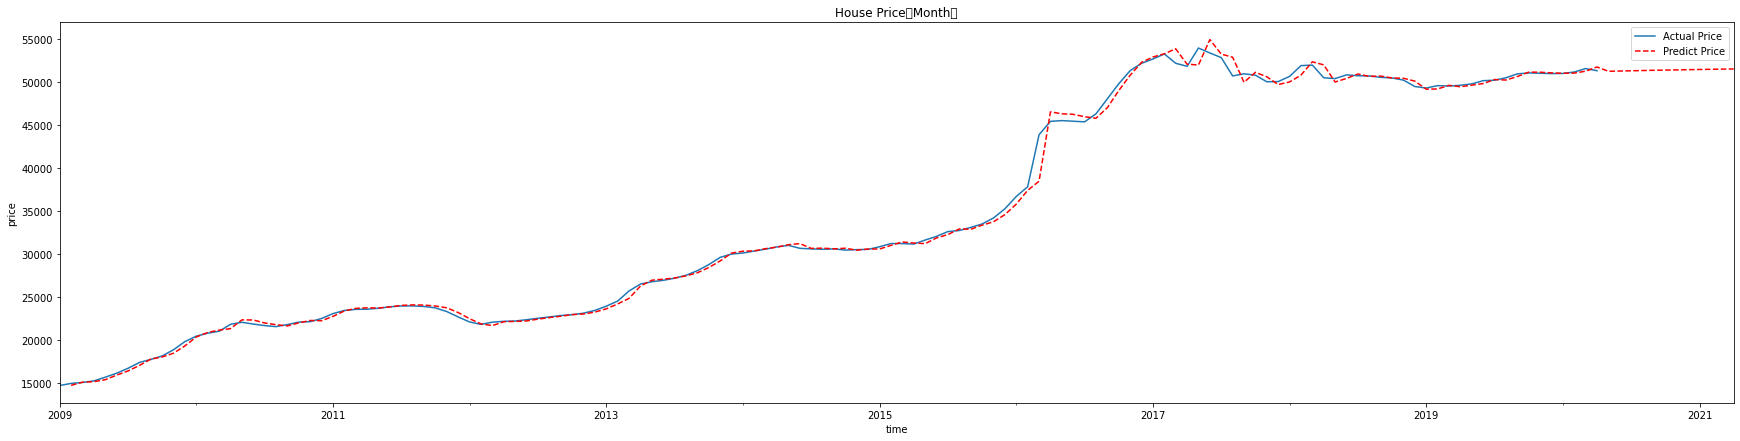

In [0]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['Price']]
future_month = 12
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的6个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN
print(df_month2)

# 房价数据预测结果显示
plt.figure(figsize=(30,7))
df_month2.Price.plot(label='Actual Price')
df_month2.forecast.plot(color='r', ls='--', label='Predict Price')
plt.legend()
plt.title('House Price（Month）')
plt.xlabel('time')
plt.ylabel('price')
plt.show()